In [23]:
import time
import itertools
import numpy as np
from scipy.optimize import minimize, basinhopping
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from modules.utils import *
%matplotlib inline
cmap = plt.get_cmap("plasma") #'viridis'
import qiskit
#%matplotlib inline

In [11]:
print(qiskit.__version__)

0.17.4


In [12]:
### Preliminaries
L = 5
num_trash = 2
logspace_size=50

name = f'VQE_Ising_L5_anti_-1_50x50'   # name of the data produced by this notebook
filename = "data/params_" + name   # name of the data file that is used

In [13]:
L = 5
anti = -1.

VQE_params = np.load(filename + ".npz", allow_pickle=True)
gx_list = VQE_params['gx_list']
gz_list = VQE_params['gz_list']
opt_params = VQE_params['opt_params']

gx_vals = np.unique(gx_list)
gz_vals = np.unique(gz_list)

mag = QMag(L,anti) #magnetization operator (Qiskit)
Smag = Mag(L,anti) #magnetization operator (numpy)
# the ~ is the adjoint, but also it turns the is_measurement attribute to True
~StateFn(mag)
# state is technically a circuit, that prepares the ground state via VQE circuit
#state.draw() # uncomment to see, but is very long

Qen=np.zeros(len(opt_params)); Sen=np.zeros(len(opt_params)) #energies
Qmags=np.zeros(len(opt_params)); Smags=np.zeros(len(opt_params)) #magnetizations

In [14]:
load = True

In [15]:
if load:
    temp = np.load(filename + "_mags-Es.npz",allow_pickle=True)
    Qmags = temp["Qmags"]
    Qen = temp["Qen"]
    Sen = temp["Sen"]
    Smags = temp["Smags"]

In [16]:
if not load:
    for j in range(len(opt_params)):

        gx = gx_list[j]
        gz = gz_list[j]
        H = QHIsing(L, anti, np.float32(gx), np.float32(gz)) # build Hamiltonian Op
        state = init_vqe(opt_params[j], L=L)
        StateFn(state)   
        meas_outcome = ~StateFn(mag) @ StateFn(state)

        Qmags[j] = meas_outcome.eval()
        e_outcome = ~StateFn(H) @ StateFn(state)
        Qen[j] = e_outcome.eval()

        init_state, E, ham = ising_groundstate(L, anti, np.float(gx), np.float(gz))
        Sen[j] = E
        Smags[j] = init_state.T.conj()@Smag@init_state #Magnetization with Numpy results
    np.savez(filename + "_mags-Es",Qmags=Qmags, Qen=Qen, Sen=Sen, Smags=Smags) # for large parameter space takes quite a while because of the exact diagonalization

## ED comparison

<ipython-input-17-f3ca36468ff1>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(gz_vals, gx_vals, abs(Smags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
<ipython-input-17-f3ca36468ff1>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(gz_vals, gx_vals, abs(Qmags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)


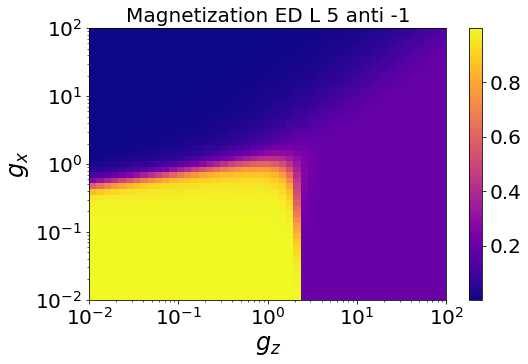

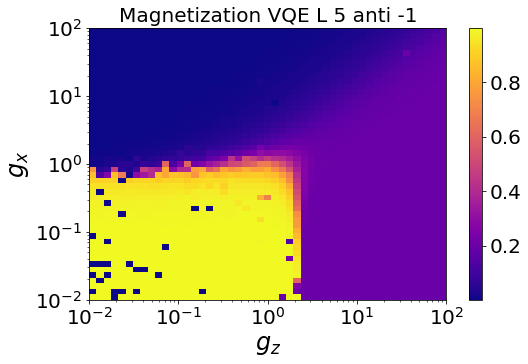

In [17]:
fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, abs(Smags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Magnetization ED L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, abs(Qmags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Magnetization VQE L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

<ipython-input-18-f44c804642c6>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(gz_vals, gx_vals, Sen.reshape(len(gz_vals),len(gx_vals)) - Qen.reshape(len(gz_vals),len(gx_vals)), cmap=cmap)


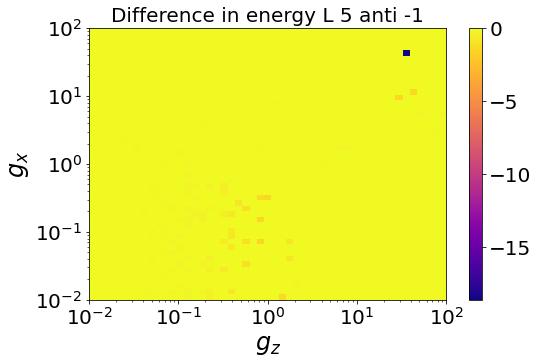

In [18]:
fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, Sen.reshape(len(gz_vals),len(gx_vals)) - Qen.reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Difference in energy L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

In [19]:
##############################################################################
### II - Training  ###########################################################
##############################################################################


# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')


thetas = np.random.uniform(0, 2*np.pi, 2*L+2) # initial parameters without feature encoding
# thetas = np.random.uniform(0, 2*np.pi, (2*L+2, 2)) # initial parameters with feature encoding

In [20]:
# linear entangler (as in scales linearly with trash qubits)
def get_entangler_map(L, num_trash, i_permut=1):
    result = []
    nums = list(range(L)) # here was the problem, it doesnt like when list elements are taken from numpy
    nums_compressed = nums.copy()[:L-num_trash]
    nums_trash = nums.copy()[-num_trash:]
    #print(nums, nums_compressed, nums_trash)
    # combine all trash qubits with themselves
    for trash_q in nums_trash[:-1]:
        result.append((trash_q+1,trash_q))
    # combine each of the trash qubits with every n-th
    repeated = list(nums_trash) * (L-num_trash) # repeat the list of trash indices cyclicly
    for i in range(L-num_trash):
        result.append((repeated[i_permut + i], nums_compressed[i]))
    return result

def QAE_Ansatz(thetas, L, num_trash, insert_barriers=False, parametrized_gate = "ry", entangling_gate = "cz"):
    entanglement = [get_entangler_map(L,num_trash,i_permut) for i_permut in range(num_trash)]
    circ = qiskit.circuit.library.TwoLocal(L, 
                                           parametrized_gate,
                                           entangling_gate,
                                           entanglement,
                                           reps=num_trash,
                                           insert_barriers=insert_barriers,
                                           skip_final_rotation_layer=True
                                          ).assign_parameters(thetas[:-num_trash])
    if insert_barriers: circ.barrier()
    for i in range(num_trash):
        circ.ry(thetas[L-i-1], L-i-1)
        #circ.ry(circuit.Parameter(f'θ{i}'), L-i-1)
    return circ

def prepare_circuit(thetas, L=6, num_trash=2, init_state=None, measurement=True, vqe=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(num_trash, 'c')
    circ = QuantumCircuit(qreg, creg)
    circ += QAE_Ansatz(thetas, L, num_trash, insert_barriers=True)#.assign_parameters(thetas) # difference to bind?
    if measurement:
        for i in range(num_trash):
            circ.measure(qreg[L-i-1], creg[i])
    if init_state is not None:
        if vqe:
            circ = init_vqe(init_state,L=L) + circ
        else:
            circ.initialize(init_state, qreg)
    return circ

In [21]:
def feature_encoding(thetas, x):
    """ thetas: parameters to be optimized, x: Ising model parameter (eg. field) """
    new_thetas = []
    thetas = thetas.reshape((-1,2))
    for theta in thetas:
        new_thetas.append(theta[0] * x + theta[1])
    return new_thetas

### Execute circuit
Circuit is executed on simulator and measurement outcomes on the trash qubits are stored

In [24]:
idx = 30
num_trash = 2
J, gx, gz = -1., gx_list[idx], gz_list[idx] # Ising parameters for which ground state should be compressed
phi = opt_params[idx] # train on smallest lambda ;; this may grammatically be confusing, init_state = dictionary with unsorted parameters

def run_circuit(thetas, L, num_trash, init_state, vqe=True, shots=100):
    circ = prepare_circuit(thetas, L, num_trash, init_state, vqe=vqe)

    # Execute the circuit on the qasm simulator.
    job_sim = execute(circ, backend_sim, shots=shots)#, memory=True)

    # Grab the results from the job.
    result_sim = job_sim.result()

    counts = result_sim.get_counts(circ)
#     print(counts)
    
#     mems = result_sim.get_memory(circ)
#     print(mems)
    return counts
run_circuit(thetas, L, num_trash, phi)['11']

<ipython-input-20-a05c1f5c1b9e>:43: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = init_vqe(init_state,L=L) + circ
/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


23

### Optimize circuit
Define cost function (averaged hamming distance of measurement outcomes) and minimze it using either scipy or qiskit optimizer modules (the latter is also based on scipy though).

In [25]:
# translate to Rikes naming
phis = opt_params
gxs = gx_list
gzs = gz_list

In [26]:
#reset random seed
np.random.seed(123)

In [32]:
def cost_function_single(thetas, L, num_trash, p, shots=1000, vqe=True, param_encoding=False, x=0):
    """ Optimizes circuit """
    if vqe:
        init_state = phis[p]
    else:
        J, gx, gz = p
        init_state, _ = ising_groundstate(L, J, gx, gz)
    if param_encoding: thetas = feature_encoding(thetas, x) 
    out = run_circuit(thetas, L, num_trash, init_state, vqe=vqe, shots=shots)
    cost = out.get('11', 0)*2 + out.get('01', 0) + out.get('10', 0)
    return cost/shots

def cost_function(thetas, L, num_trash, ising_params, shots=1000, vqe=True, param_encoding=False, x=0):
    """ Optimizes circuit """
    cost = 0.
    n_samples = len(ising_params)
    for i, p in enumerate(ising_params):
        if param_encoding: 
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding, x[i])
        else:
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding)
    return cost/n_samples

def optimize(ising_params, L=6, num_trash=2, thetas=None, shots=1000, max_iter=400, vqe=True, param_encoding=False, x=0):
    if thetas is None:
        n_params = (2*L+2)*2 if param_encoding else (2*L+2)
        thetas = np.random.uniform(0, 2*np.pi, n_params) # initial parameters without feature encoding
        
    print("Initial cost: {:.3f}".format(cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x)))
    
    counts, values, accepted = [], [], []
    def store_intermediate_result(eval_count, parameters, mean, std, ac):
        # counts.append(eval_count)
        values.append(mean)
        accepted.append(ac)

    # Initialize optimizer
    # optimizer = COBYLA(maxiter=max_iter, tol=0.0001)
    # optimizer = L_BFGS_B(maxfun=300, maxiter=max_iter)#, factr=10, iprint=- 1, epsilon=1e-08)
    optimizer = SPSA(maxiter=max_iter,
                     #blocking=True,
                     callback=store_intermediate_result,
                     #learning_rate=1e-1,
                     #perturbation=0.4
                     ) # recommended from qiskit (first iteraction takes quite long)
                       # to reduce time figure out optimal learning rate and perturbation in advance

    start_time = time.time()
    ret = optimizer.optimize(
                            num_vars=len(thetas),
                            objective_function=(lambda thetas: cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x)),
                            initial_point=thetas
                            )
    print("Time: {:.5f} sec".format(time.time()-start_time))
    print(ret)
    return ret[0], values, accepted

## Training on bottom-left

In [44]:
# Testing
params = [0]
thetas, loss, accepted = optimize(params, max_iter=100, L=5)

Initial cost: 1.252
Time: 23.79183 sec
(array([ 6.21109692,  3.0890336 ,  6.32084798,  4.6896816 ,  4.67866932,
        0.23815474,  3.11829771,  0.2451395 , -0.20426403,  2.95346985,
        1.35059133,  4.76036561]), 0.036, 300)


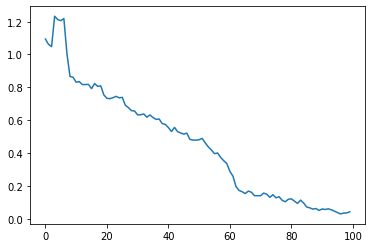

In [45]:
plt.plot(loss)

## Inference

In [46]:
points = 50
J = -1.0
x,y = np.meshgrid(gx_vals, gz_vals)
cost = np.zeros((len(gx_vals) * len(gz_vals)))
Smags = np.zeros((len(gx_vals) * len(gz_vals)))
shots = 1000
for i,p in enumerate(list(zip(gxs, gzs))):
        cost[i] = cost_function_single(thetas, L, num_trash, i, shots=shots)
cost = cost.reshape((len(gx_vals), len(gz_vals)))

<ipython-input-47-a9b0e287b09f>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
<ipython-input-47-a9b0e287b09f>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(gz_vals, gx_vals, abs(Qmags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)


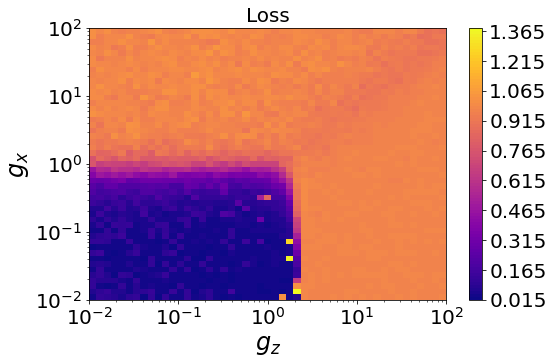

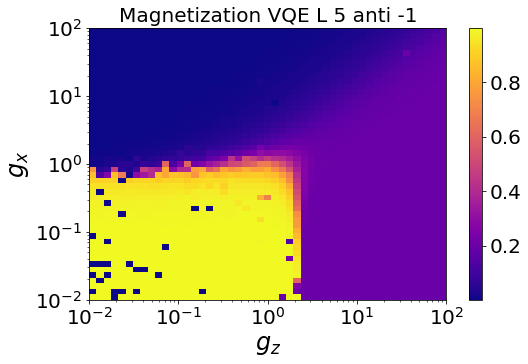

In [47]:
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, abs(Qmags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Magnetization VQE L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

## Training top left

In [53]:
params = np.intersect1d(np.where(gx_list > 99),np.where(gz_list == 1e-2))

In [54]:
thetas, loss, accepted = optimize(params, max_iter=100, L=5)

Initial cost: 0.753
Time: 23.89446 sec
(array([ 0.85692702,  4.70564088,  0.53008582,  4.77051259,  3.25170121,
       -0.70286783,  0.00993703,  8.18594211,  4.74596745,  4.60887096,
        3.30755791,  4.67245911]), 0.004, 300)


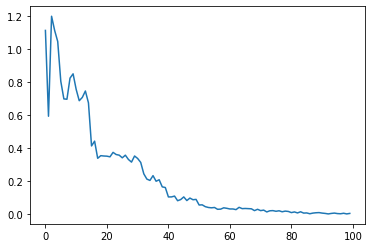

In [55]:
plt.plot(loss)

## Inference

In [56]:
points = 50
J = -1.0
x,y = np.meshgrid(gx_vals, gz_vals)
cost = np.zeros((len(gx_vals) * len(gz_vals)))
Smags = np.zeros((len(gx_vals) * len(gz_vals)))
shots = 1000
for i,p in enumerate(list(zip(gxs, gzs))):
        cost[i] = cost_function_single(thetas, L, num_trash, i, shots=shots)
cost = cost.reshape((len(gx_vals), len(gz_vals)))

<ipython-input-57-a9b0e287b09f>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
<ipython-input-57-a9b0e287b09f>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(gz_vals, gx_vals, abs(Qmags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)


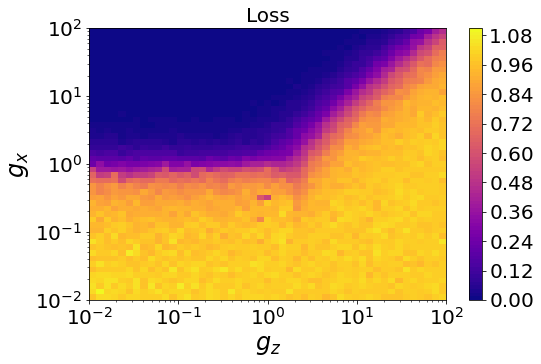

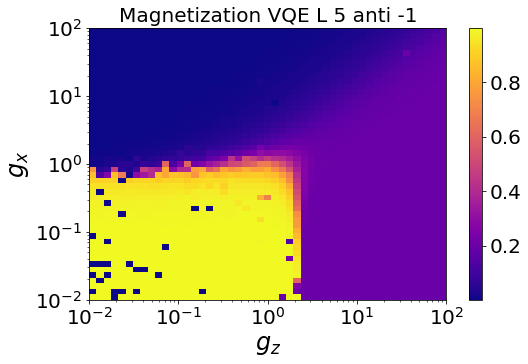

In [57]:
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, abs(Qmags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Magnetization VQE L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

## Training top left and bottom right

In [60]:
params = list(np.intersect1d(np.where(gx_list > 99),np.where(gz_list == 1e-2)))

In [61]:
params.append(np.intersect1d(np.where(gz_list > 99),np.where(gx_list == 1e-2))[0])

In [63]:
for p in params:
    print(f"gz = {gz_list[p]}; gx = {gx_list[p]}")

gz = 0.01; gx = 100.0
gz = 100.0; gx = 0.01


In [64]:
thetas, loss, accepted = optimize(params, max_iter=100, L=5)

Initial cost: 0.970
Time: 46.93416 sec
(array([6.09263408, 5.79873841, 3.22127461, 1.0742965 , 1.08137915,
       3.18258676, 3.42717213, 6.22409451, 1.79125377, 5.06751456,
       3.02470056, 2.69091512]), 0.3175, 300)


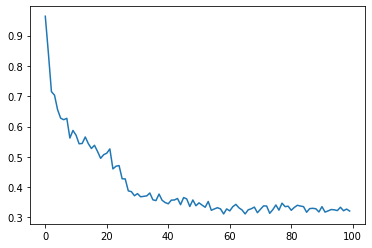

In [65]:
plt.plot(loss)

## Inference

In [66]:
points = 50
J = -1.0
x,y = np.meshgrid(gx_vals, gz_vals)
cost = np.zeros((len(gx_vals) * len(gz_vals)))
Smags = np.zeros((len(gx_vals) * len(gz_vals)))
shots = 1000
for i,p in enumerate(list(zip(gxs, gzs))):
        cost[i] = cost_function_single(thetas, L, num_trash, i, shots=shots)
cost = cost.reshape((len(gx_vals), len(gz_vals)))

<ipython-input-71-6d0fd355f5a3>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
<ipython-input-71-6d0fd355f5a3>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(gz_vals, gx_vals, abs(Qmags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)


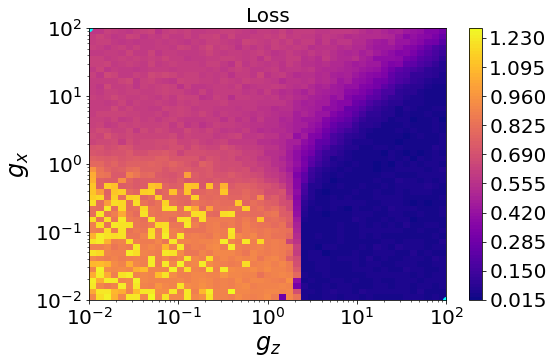

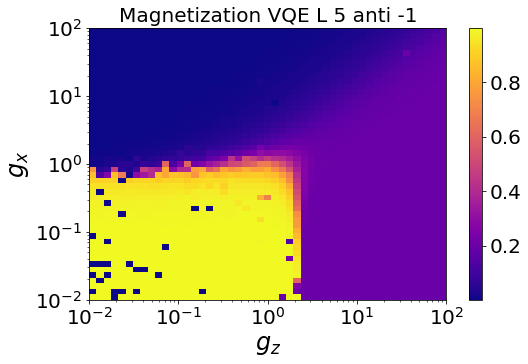

In [71]:
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)
for p in params:
    gz = gz_list[p]
    gx = gx_list[p]
    ax.plot(gx,gz,"o",label="training",color="cyan")

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, abs(Qmags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Magnetization VQE L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)